# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the complessive pollution estimatins and compute AQI values.

In [43]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Notebook Setup

In [44]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [45]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 8,
        offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10


In [46]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [47]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## Agents Estimations

Prepare a dictionary containing the model to use for each agent of each station

In [48]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

lstm = ('LSTM', buid_lstm_model, lstm_params, lstm_train_params, True)

In [49]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params2 = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params2 = {
    'epochs':10,
    'batch_size':32,
}

LSTM_old = ('LSTM-old',buid_lstm_model, lstm_params2, lstm_train_params2, True)

In [50]:
def buid_lstm_2_model(time_steps, n_features, optimizer='adam', loss='mean_squared_error'):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(time_steps, n_features)),
        LSTM(32, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error'
}

lstm_2_train_params = {
    'epochs':20,
    'batch_size':32,
}

LSTM_2 = ('LSTM_2',buid_lstm_2_model, lstm_2_params, lstm_2_train_params, True)

In [51]:
def build_ffnn_3_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024*2, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512*2, activation='relu'), 
        Dropout(0.2),
        Dense(256*2, activation='relu'),  
        Dropout(0.2),
        Dense(128*2, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_3_params = {
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

ffnn_3_train_params = {
    'epochs':20,
    'batch_size':64,
}

FFNN3 = ('Feed Forward NN 3',build_ffnn_3_model, ffnn_3_params, ffnn_3_train_params, False)

In [52]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

FFNN = ('Feed Forward NN',build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [53]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

xgb = ('Random Forest Regressor',RandomForestRegressor, rfr_params, None, False)

In [54]:
models = {
    'GIARDINI MARGHERITA':{
        'NO2':lstm, 
        'O3':LSTM_old, 
        'PM10':xgb,
        'PM2.5':xgb 
    },
    'PORTA SAN FELICE':{
        'C6H6':lstm, 
        'CO':FFNN, 
        'NO2':FFNN3, 
        'PM10':xgb,  
        'PM2.5':xgb 
    },
    'VIA CHIARINI':{
        'NO2':FFNN, 
        'O3':LSTM_2, 
        'PM10':xgb  
    }
}

In [55]:
agents_predictions = train_agents(models, training_sets, test_sets)

Predicting NO2 in GIARDINI MARGHERITA using LSTM...
Predicting O3 in GIARDINI MARGHERITA using LSTM-old...
Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor...
Predicting PM2.5 in GIARDINI MARGHERITA using Random Forest Regressor...
Predicting C6H6 in PORTA SAN FELICE using LSTM...
Predicting CO in PORTA SAN FELICE using Feed Forward NN...
Predicting NO2 in PORTA SAN FELICE using Feed Forward NN 3...
Predicting PM10 in PORTA SAN FELICE using Random Forest Regressor...
Predicting PM2.5 in PORTA SAN FELICE using Random Forest Regressor...
Predicting NO2 in VIA CHIARINI using Feed Forward NN...
Predicting O3 in VIA CHIARINI using LSTM_2...
Predicting PM10 in VIA CHIARINI using Random Forest Regressor...


## AQI calculation

In [100]:
def merge_AQIs(AQI_dict, period):
    if period not in ('day', 'hour'): 
        return ValueError(f'Period can only be `day` or `hour`. Got {period} instead')
    hour = period == 'hour'
    freq = '1h' if hour else 'D'

    station_AQIs = {}
    for station in AQI_dict.keys():
        agents = list(AQI_dict[station].keys())
        aqi_df = AQI_dict[station][agents[0]].copy()
        
        aqi_df.loc[:, 'agent'] = agents[0]
        for key in agents[1:]:
            aux = AQI_dict[station][key].copy()
            if(len(aux) > 0): # if the aqi is hourly but pm is excluded the pm df is empty
                aux.loc[:, 'agent'] = key
                aqi_df = pd.concat([aqi_df, aux])

        if(len(aqi_df) == 0):
            print('Empty dataframe... check the date range!')
            return

        aqi_df = aqi_df.fillna(-np.inf)
        aqi_df = aqi_df.sort_values(['AQI']) # why?
        aqi_df = aqi_df.reset_index()
        aqi_df = aqi_df.drop_duplicates(subset='Date', keep='last')
        aqi_df = aqi_df.set_index('Date')
        aqi_df = aqi_df.resample(freq).max()
        aqi_df.loc[:, 'agent'] = aqi_df['agent'].fillna('missing')

        station_AQIs[station] = aqi_df
        
    return station_AQIs

In [107]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions[s][agent], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        breakpoints=True
                        ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions[s][agent],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       breakpoints=False,
                       include_hourly_pm=False
                       ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [109]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        breakpoints=True
                        ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       breakpoints=False,
                       include_hourly_pm=False
                       ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

In [123]:
def AQI_difference(pred, true):
    diff = pd.DataFrame(pred['AQI'] - true['AQI'])
    diff['agent'] = (pred['agent'] == true['agent']
                        ).astype(int).apply(lambda x: 'Same agent' if x else 'Different agents')
    
    return diff

In [125]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## AQI Comparison

In [300]:
categories = {
    'Good': 0,
    'Moderate': 25,
    'Poor': 50,
    'Very Poor': 75,
    'Severe': 100,
}

### Hourly AQI

Station GIARDINI MARGHERITA AQI:


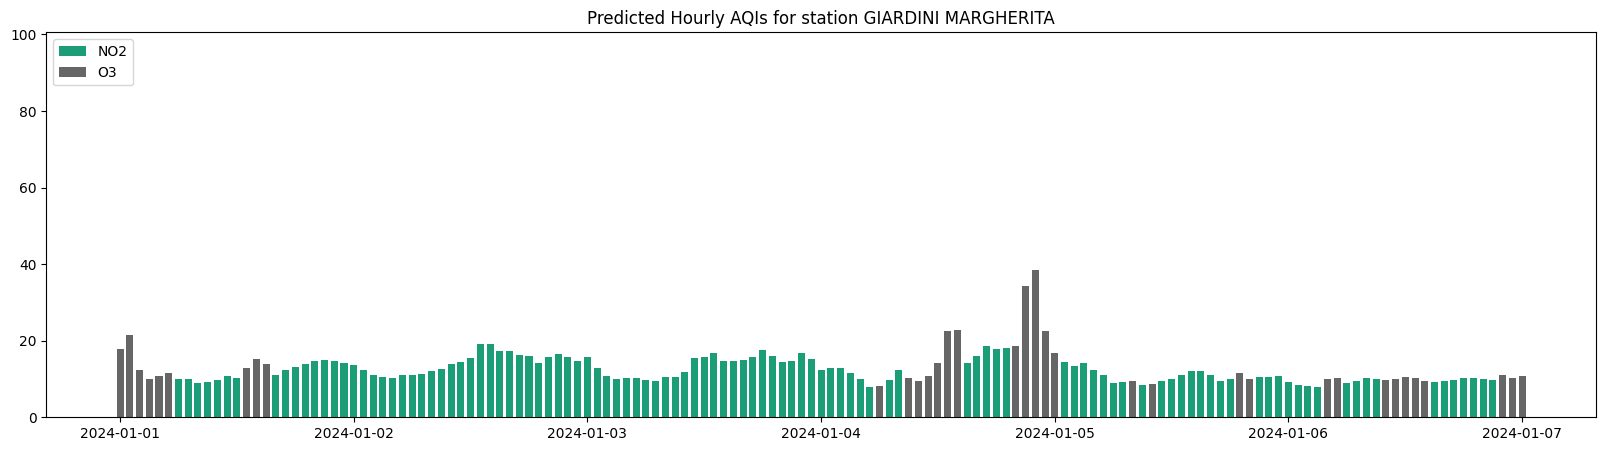

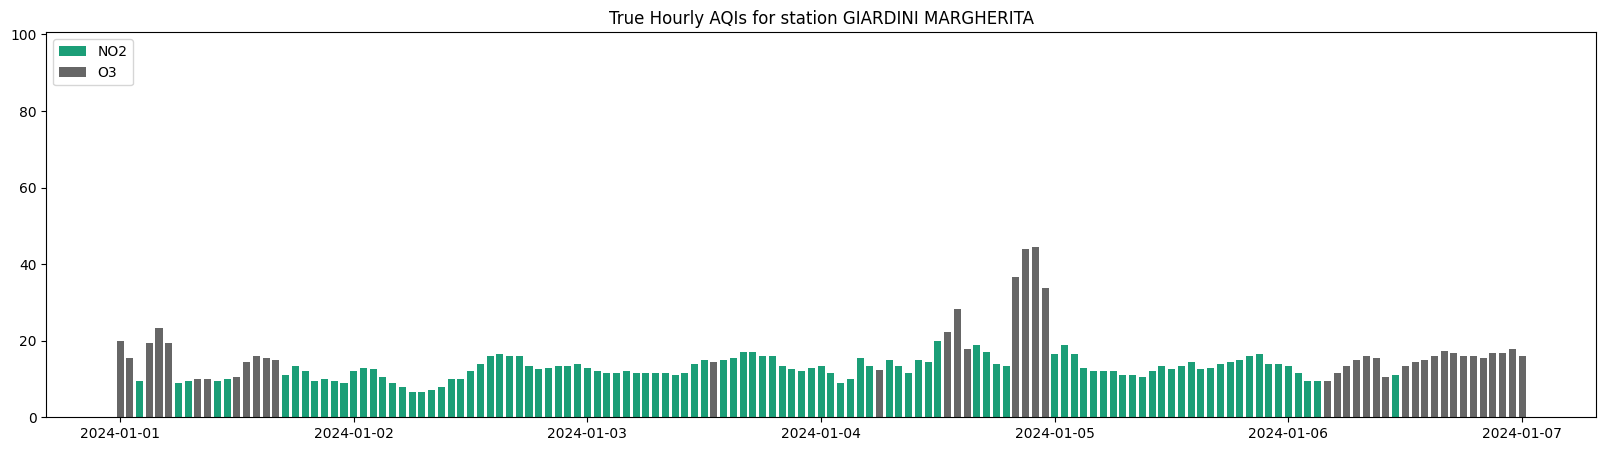

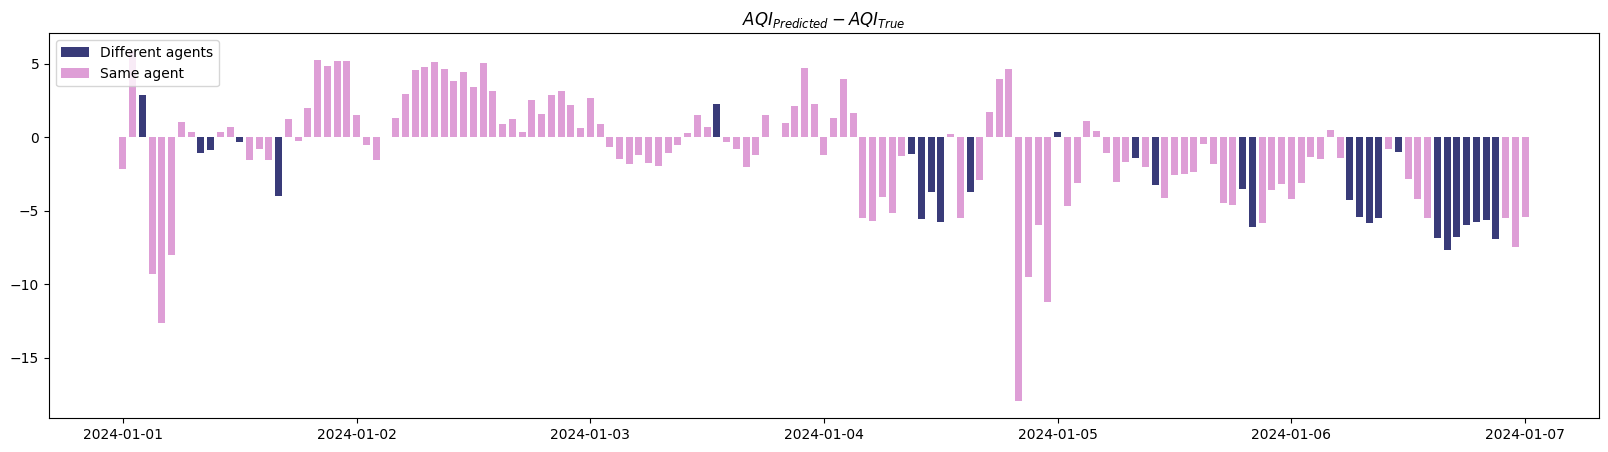

Station PORTA SAN FELICE AQI:


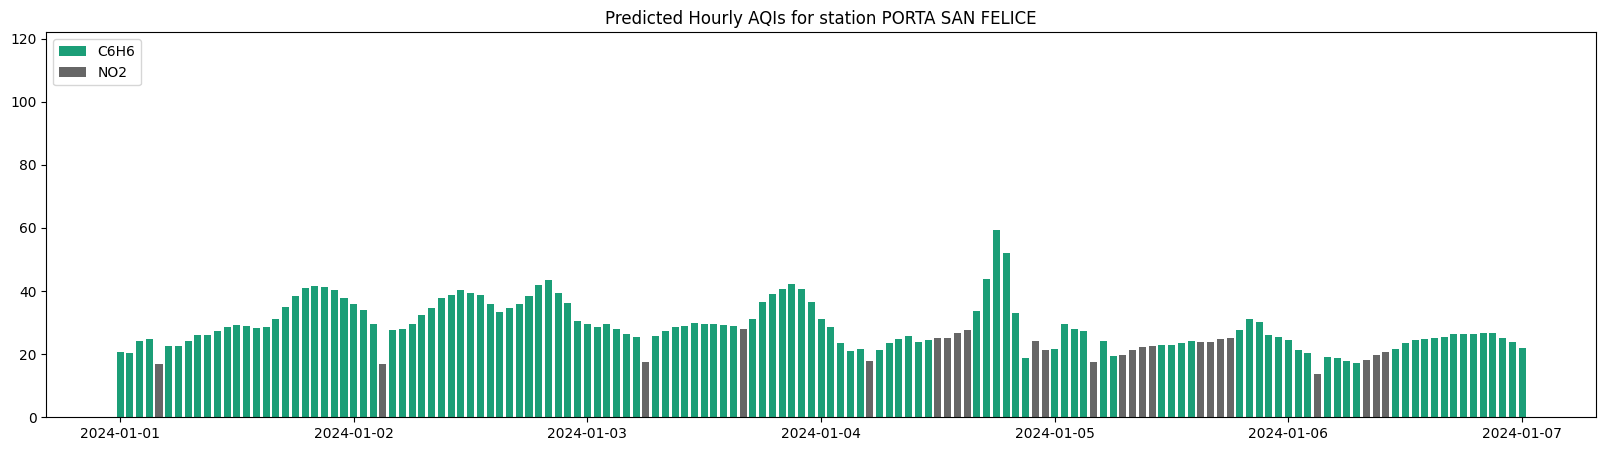

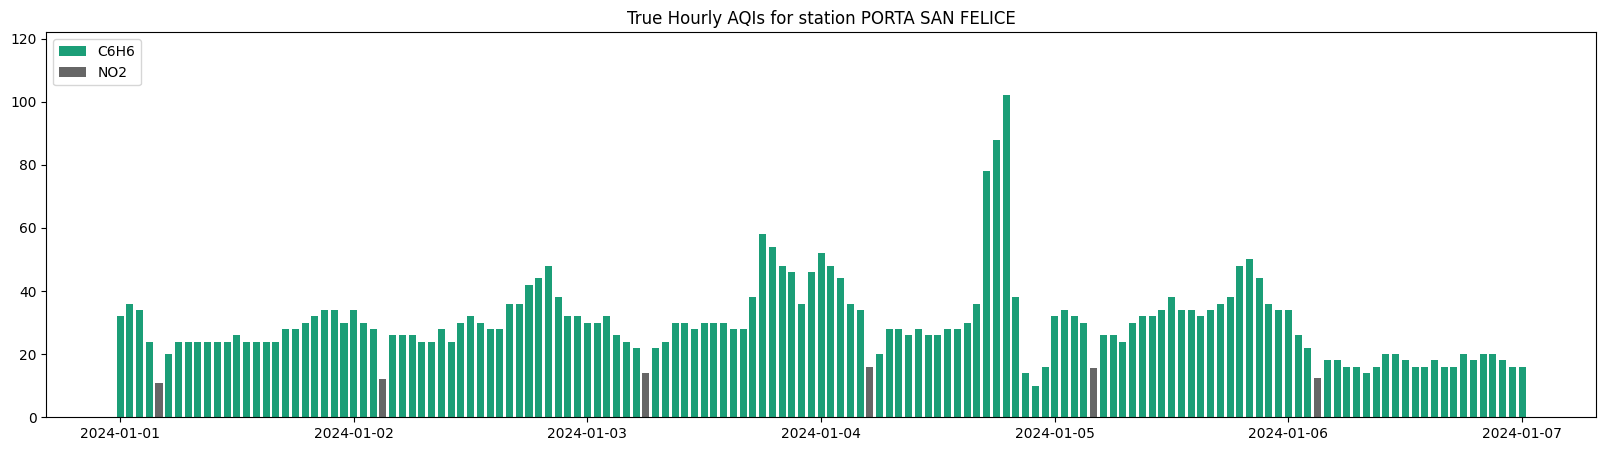

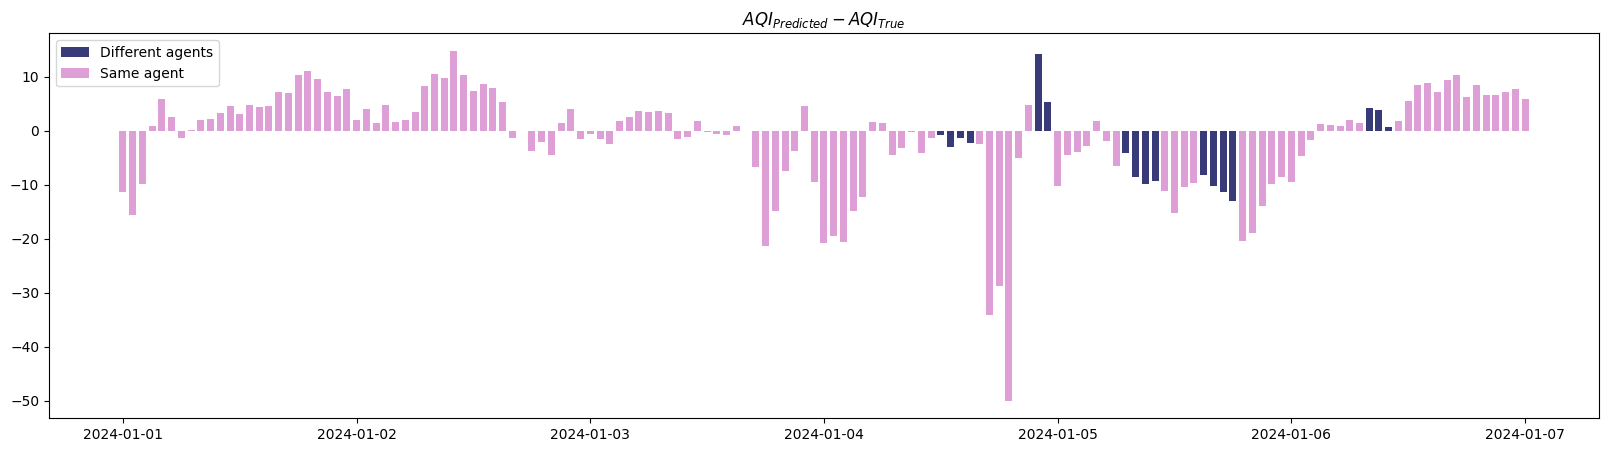

Station VIA CHIARINI AQI:


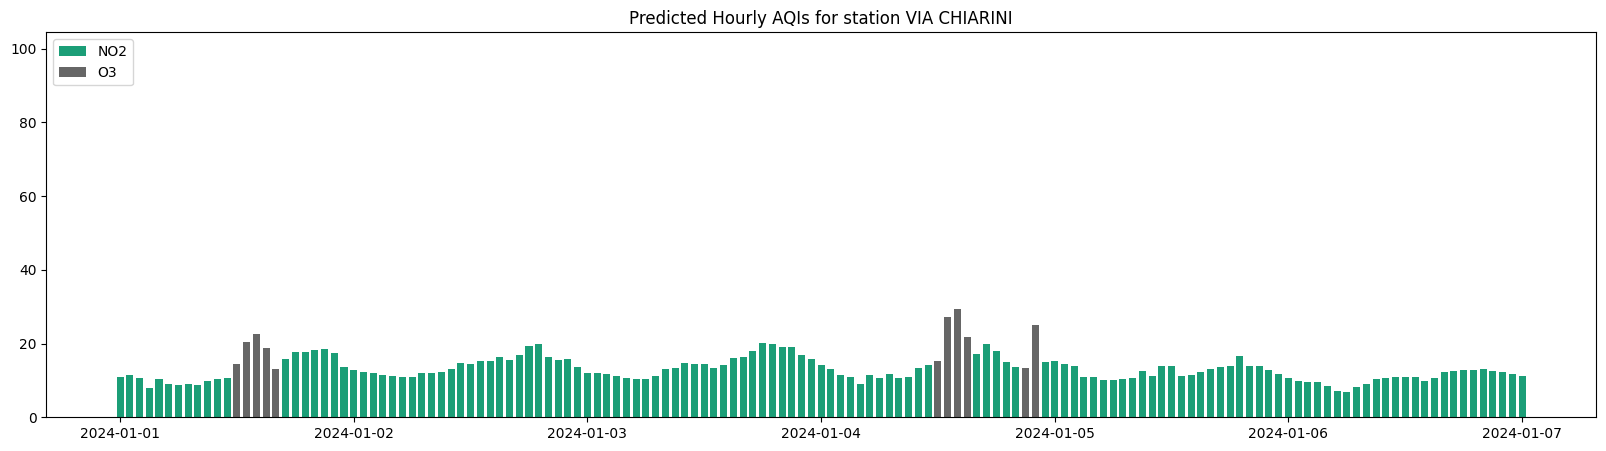

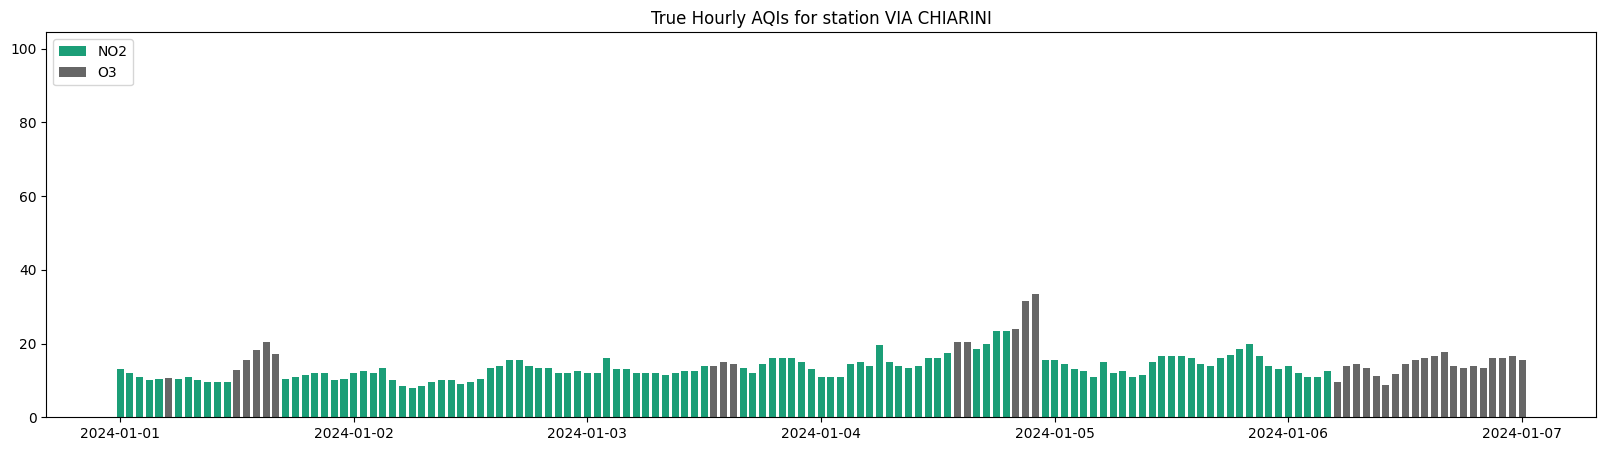

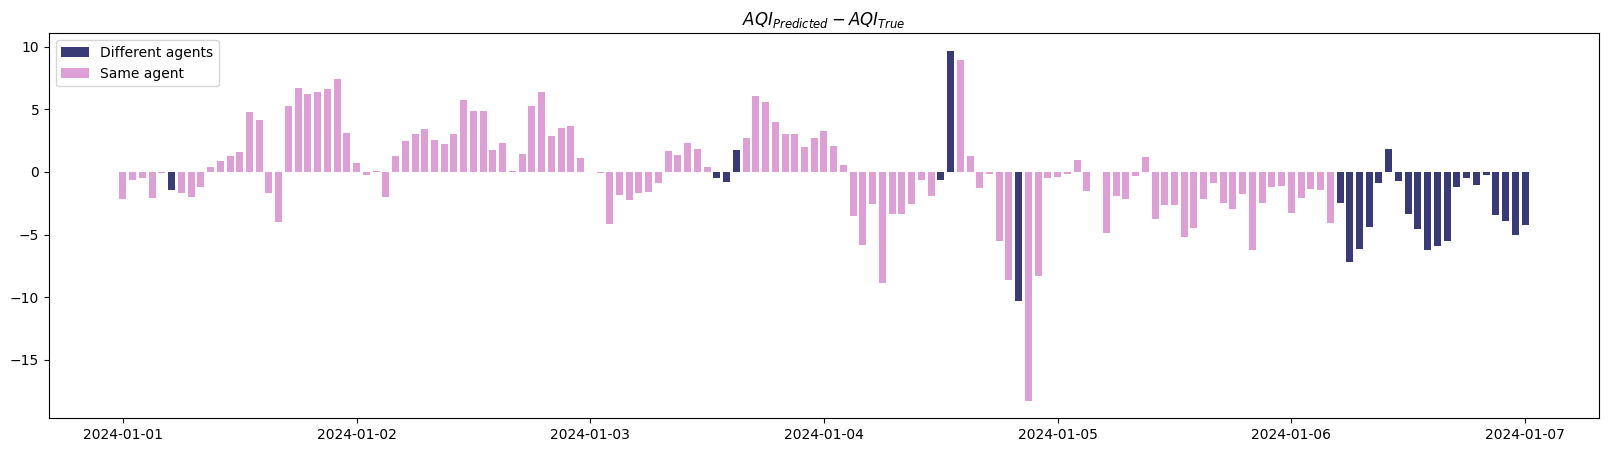

In [ ]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_hourly[station]['AQI'].max(),true_AQI_hourly[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        figsize=(20, 5), s=start, e=end, ylims=ylims)

In [ ]:
def print_AQI_difference_metrics(AQI_diff):
    positive_avg = AQI_diff[AQI_diff['AQI'] > 0]['AQI'].mean()
    negative_avg = AQI_diff[AQI_diff['AQI'] < 0]['AQI'].mean()
    absolute_mean = AQI_diff['AQI'].abs().mean()
    agent_percentage = AQI_diff['agent'].value_counts(normalize=True) * 100
    positive_percentage = (AQI_diff['AQI'] > 0).mean() * 100
    negative_percentage = (AQI_diff['AQI'] < 0).mean() * 100

    print(f"> Absolute Mean AQI Difference: {absolute_mean:.2f}")
    print(f"> Positive Average AQI Difference: {positive_avg:.2f}")
    print(f"> Negative Average AQI Difference: {negative_avg:.2f}")
    print(f"> Percentage of Positive Differences: {positive_percentage:.2f}%")
    print(f"> Percentage of Negative Differences: {negative_percentage:.2f}%")
    print("> Percentage of Agent Values:")
    display_metric_scores(agent_percentage.to_dict(), start='   ', round=2)

In [286]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def map_category(value, categories):
    for category, up_bound in reversed(list(categories.items())):
        if value > up_bound:
            return category

def print_AQI_category_comparison(pred_AQI, true_AQI, categories):
    pred_categories = pred_AQI['AQI'].copy().dropna().apply(map_category, categories=categories)
    true_categories = true_AQI['AQI'].copy().dropna().apply(map_category, categories=categories)
    
    cm = confusion_matrix(true_categories, pred_categories, labels=list(categories.keys()),normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(categories.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'AQI Categories Predictions ({cm.trace():.2f}% correct)')
    plt.show()

Station GIARDINI MARGHERITA
---------------------------------------------


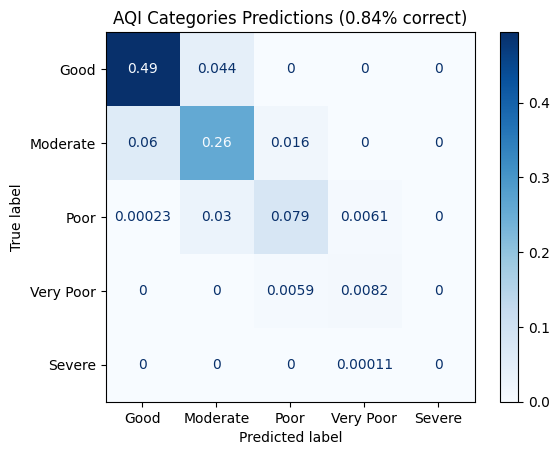

---------------------------------------------
> Absolute Mean AQI Difference: 5.06
> Positive Average AQI Difference: 4.59
> Negative Average AQI Difference: -5.51
> Percentage of Positive Differences: 48.29%
> Percentage of Negative Differences: 51.49%
> Percentage of Agent Values:
   - Same agent: 89.22
   - Different agents: 10.78


In [ ]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station PORTA SAN FELICE
---------------------------------------------


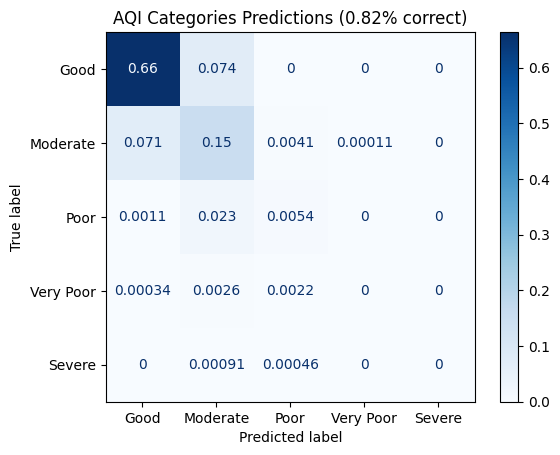

---------------------------------------------
> Absolute Mean AQI Difference: 5.84
> Positive Average AQI Difference: 5.03
> Negative Average AQI Difference: -6.76
> Percentage of Positive Differences: 53.32%
> Percentage of Negative Differences: 46.49%
> Percentage of Agent Values:
   - Same agent: 62.5
   - Different agents: 37.5


In [ ]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station VIA CHIARINI
---------------------------------------------


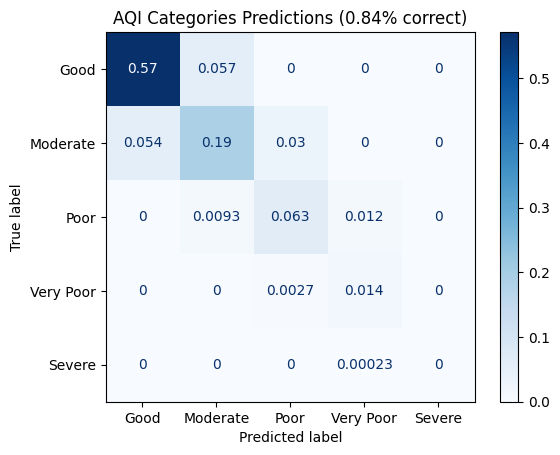

---------------------------------------------
> Absolute Mean AQI Difference: 4.99
> Positive Average AQI Difference: 5.22
> Negative Average AQI Difference: -4.72
> Percentage of Positive Differences: 53.65%
> Percentage of Negative Differences: 46.04%
> Percentage of Agent Values:
   - Same agent: 86.21
   - Different agents: 13.79


In [ ]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

### Daily AQI

Station GIARDINI MARGHERITA AQI:


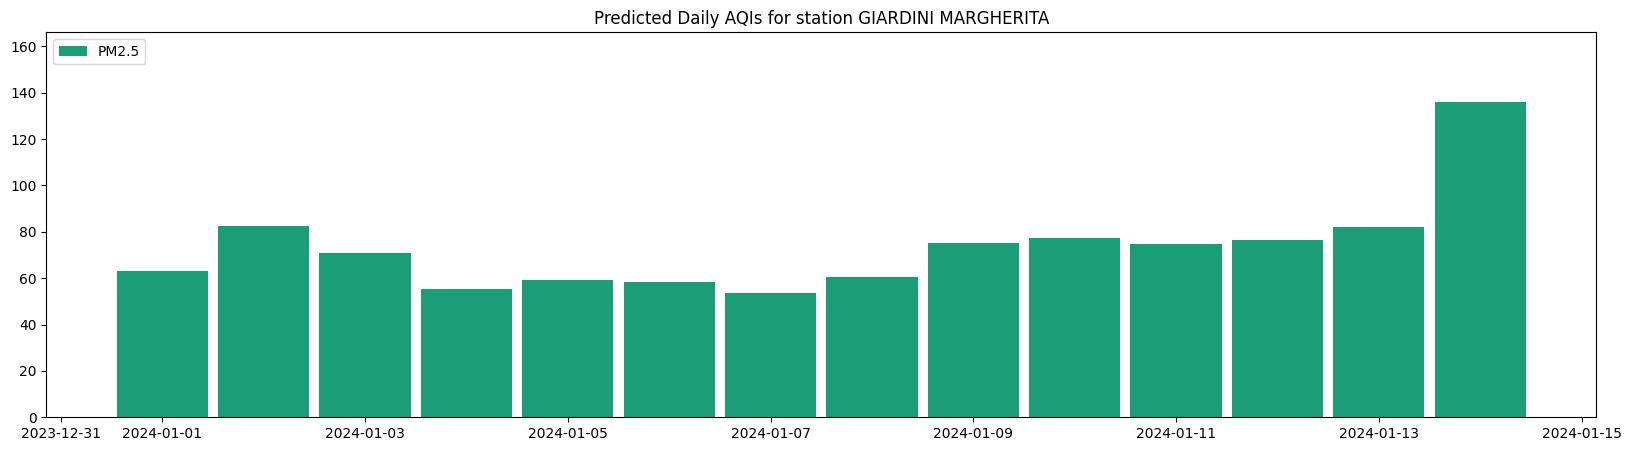

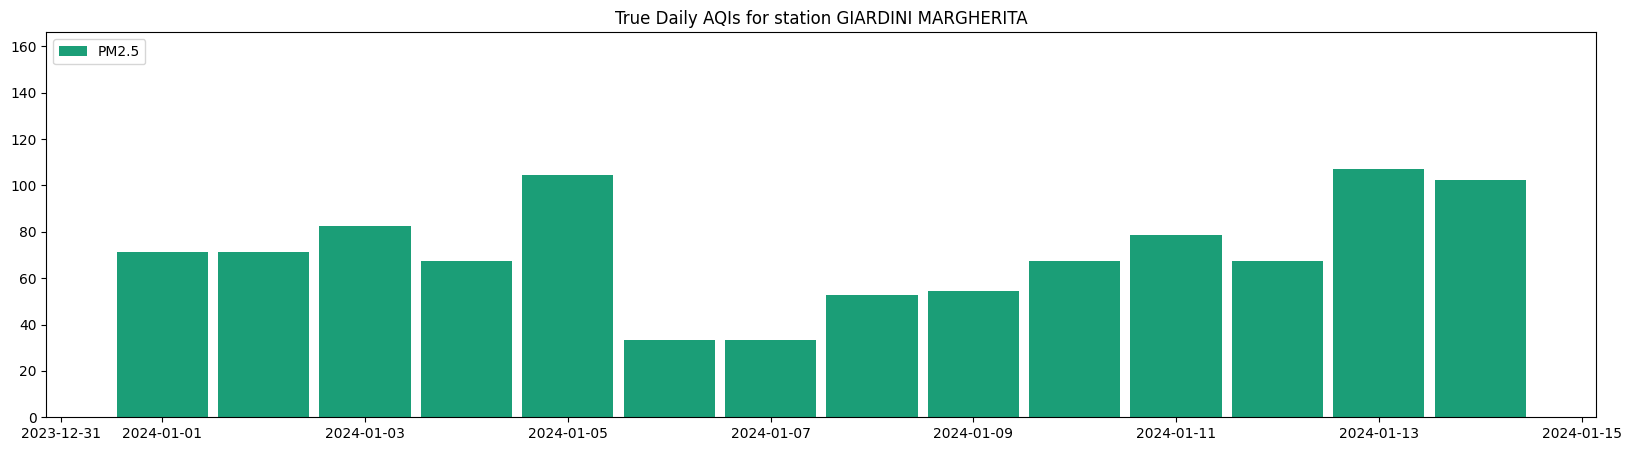

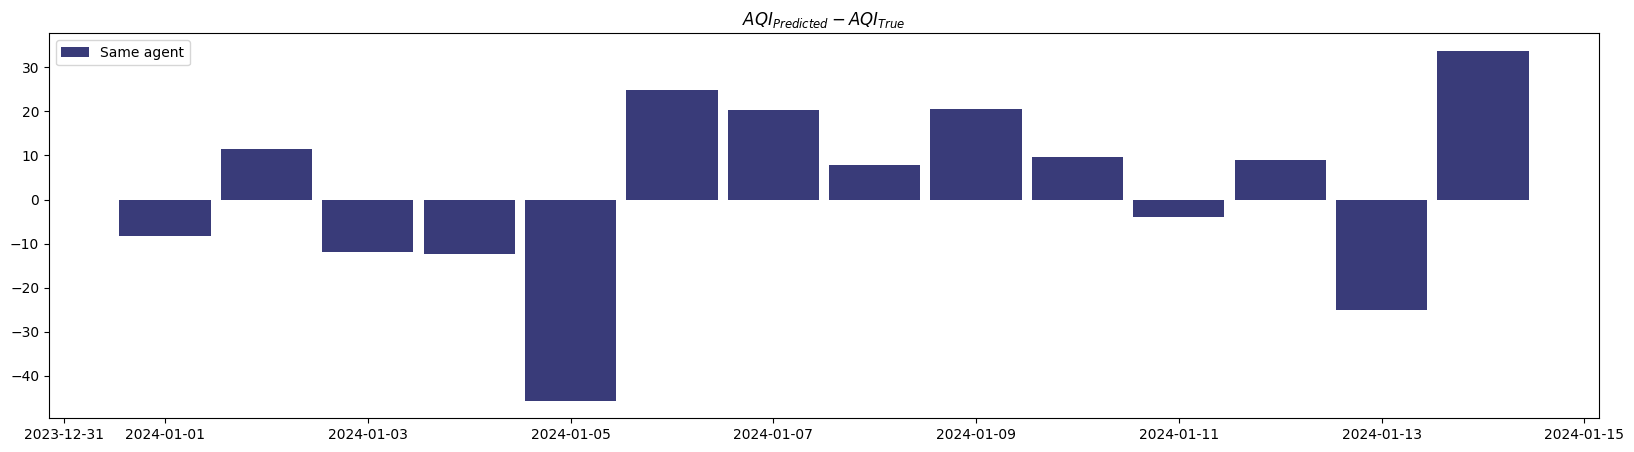

Station PORTA SAN FELICE AQI:


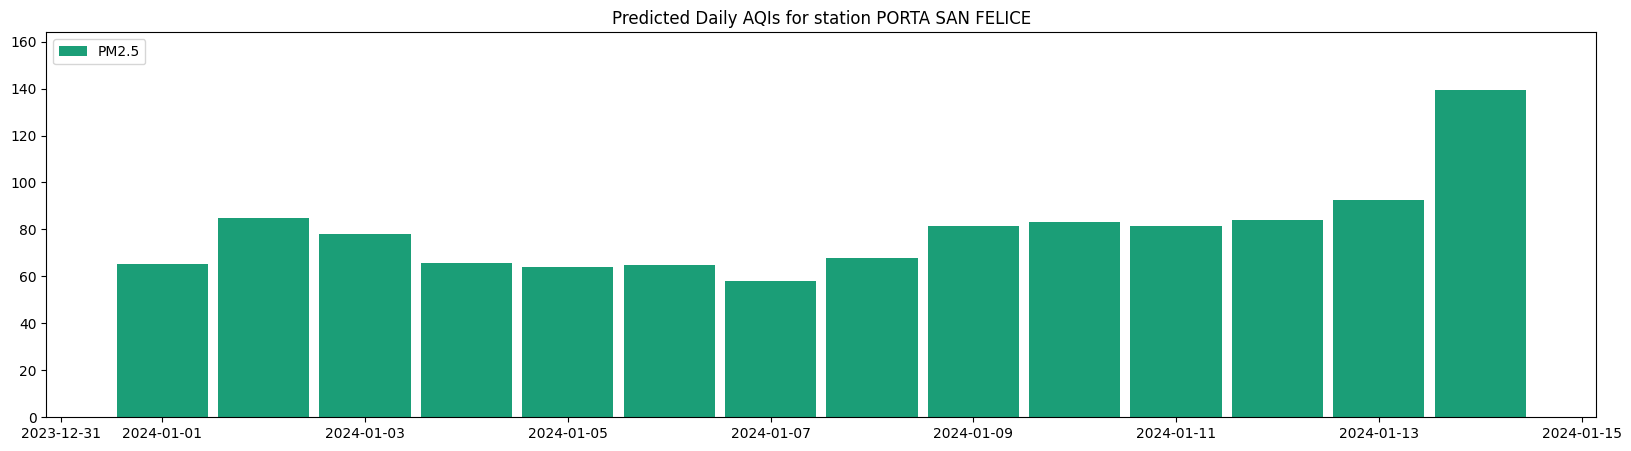

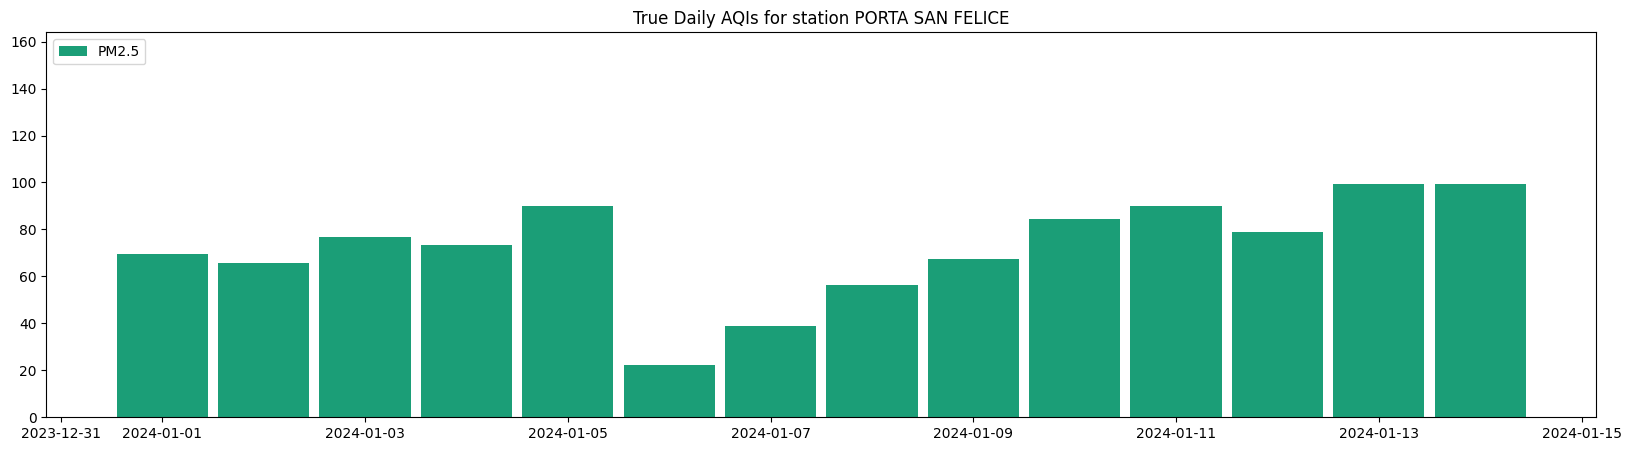

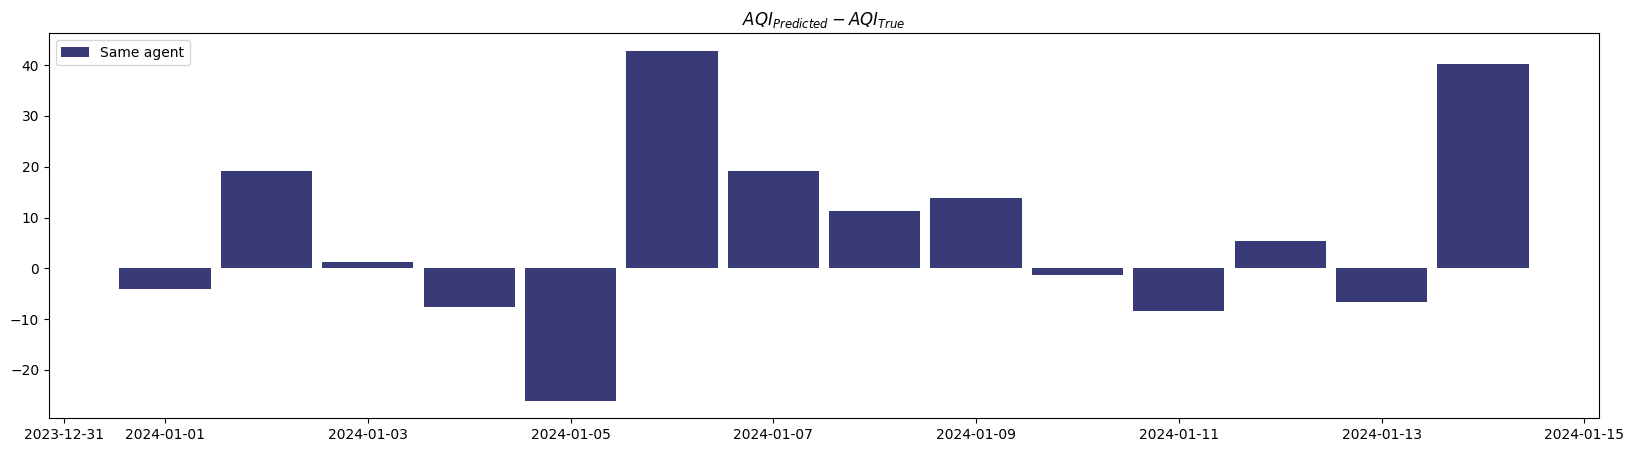

Station VIA CHIARINI AQI:


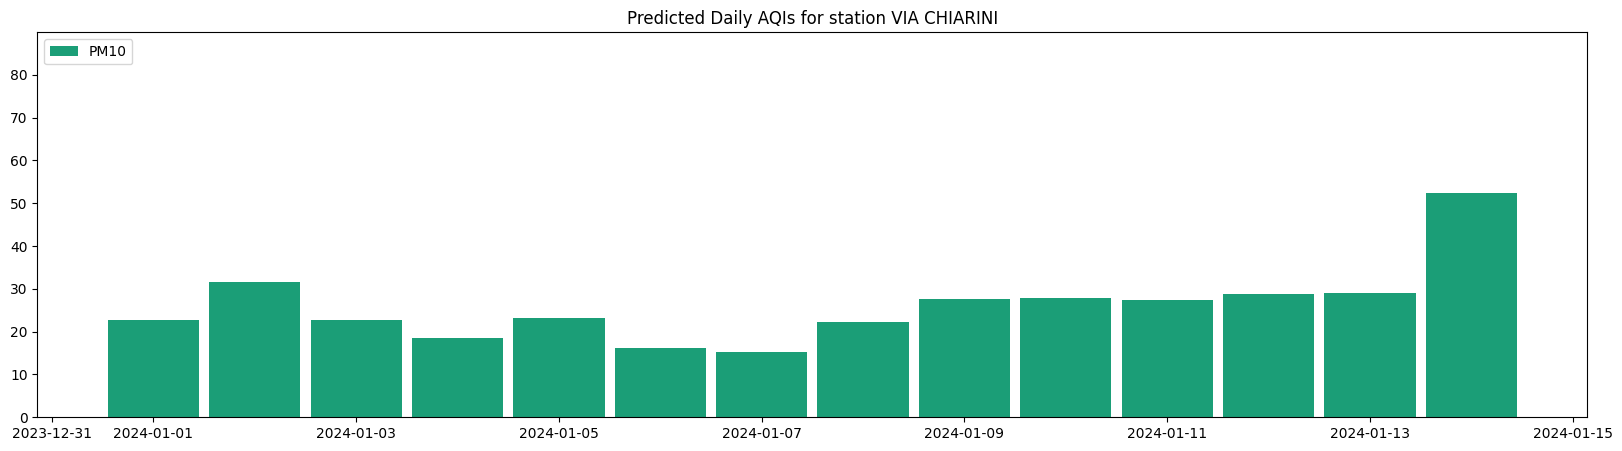

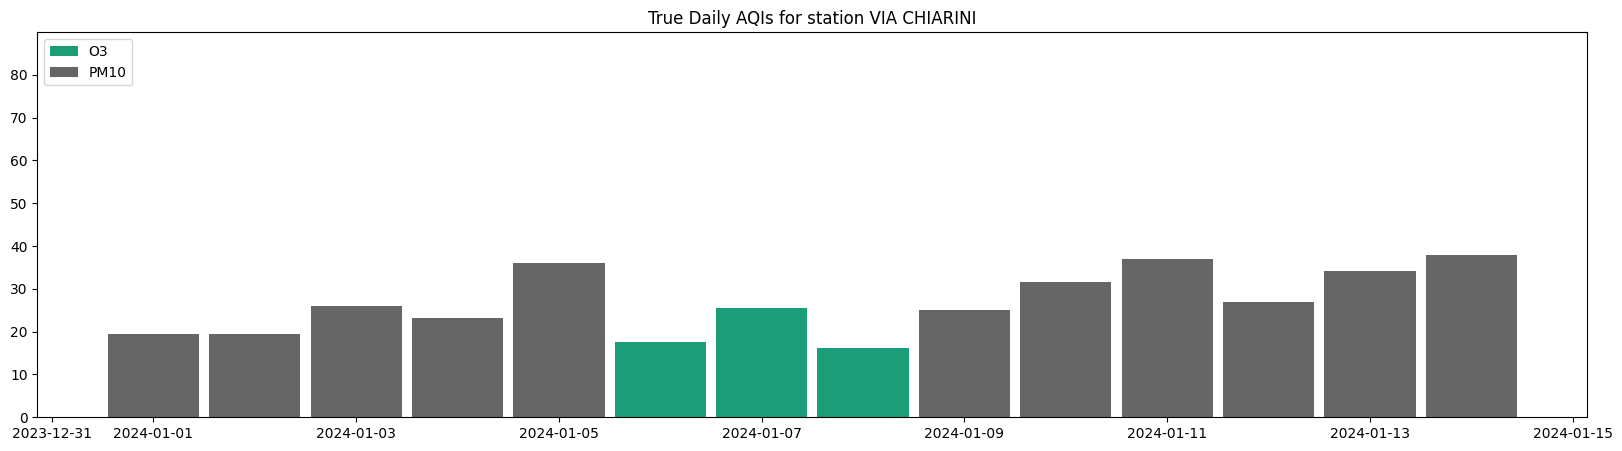

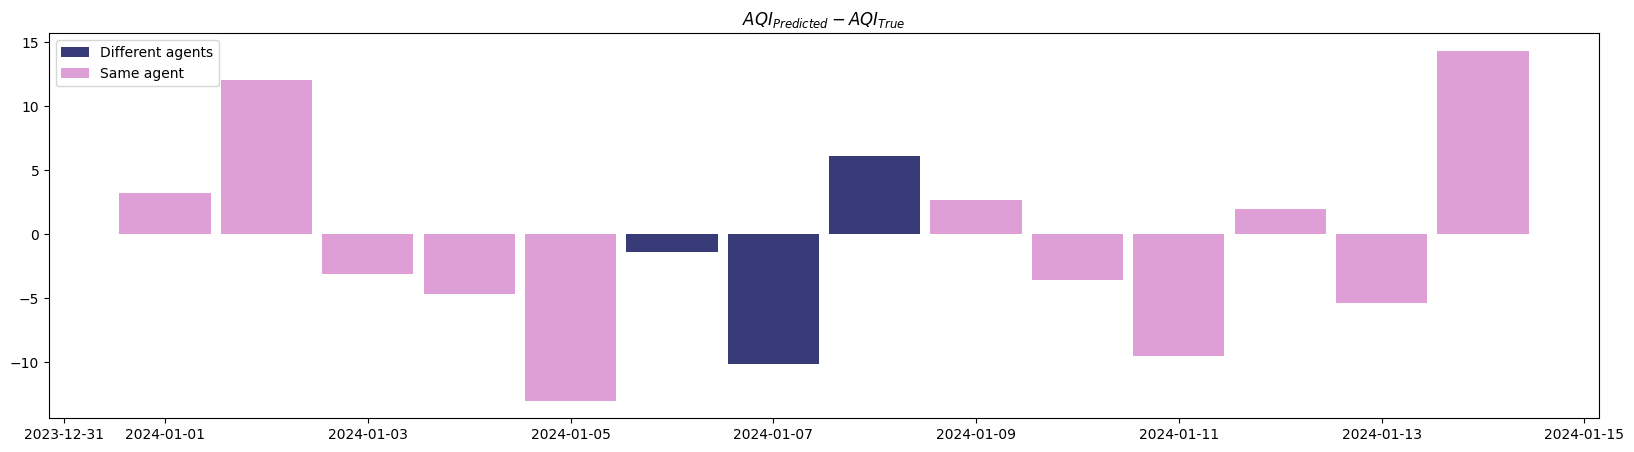

In [296]:
start=datetime(2024,1,1)
end=datetime(2024,1,14)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_daily[station]['AQI'].max(),true_AQI_daily[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        figsize=(20, 5), s=start,e=end,ylims=ylims)

Station GIARDINI MARGHERITA


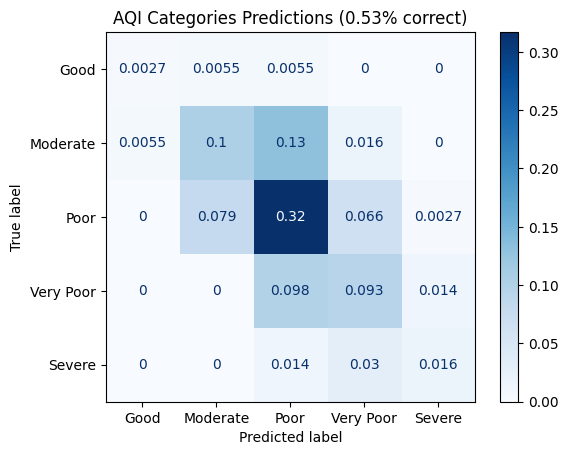

---------------------------------------------
> Absolute Mean AQI Difference: 13.28
> Positive Average AQI Difference: 13.34
> Negative Average AQI Difference: -13.22
> Percentage of Positive Differences: 48.36%
> Percentage of Negative Differences: 51.64%
> Percentage of Agent Values:
   - Same agent: 85.25
   - Different agents: 14.75


In [301]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

Station PORTA SAN FELICE


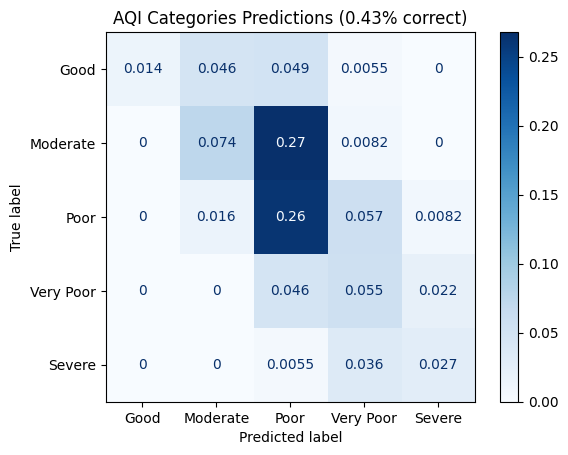

---------------------------------------------
> Absolute Mean AQI Difference: 15.57
> Positive Average AQI Difference: 16.20
> Negative Average AQI Difference: -13.99
> Percentage of Positive Differences: 71.58%
> Percentage of Negative Differences: 28.42%
> Percentage of Agent Values:
   - Same agent: 95.36
   - Different agents: 4.64


In [302]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

Station VIA CHIARINI


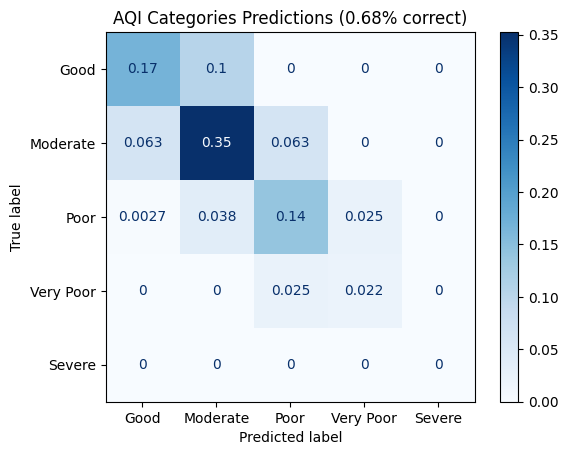

---------------------------------------------
> Absolute Mean AQI Difference: 6.67
> Positive Average AQI Difference: 6.69
> Negative Average AQI Difference: -6.62
> Percentage of Positive Differences: 64.21%
> Percentage of Negative Differences: 35.79%
> Percentage of Agent Values:
   - Same agent: 87.43
   - Different agents: 12.57


In [303]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')